&nbsp;

# 3. Feature Engineering
Feature engineering is the process of selecting, manipulating, and transforming raw data into features that can be used in supervised learning. Feature engineering is one of the most important steps when it comes to a machine learning project because algorithms can only interpret data in a certain way (numerical). For example, categorical data must be binary encoded for it to be considered during the fitting process. Furthermore, there could be features that disrupt the correlation between the label and other features, so removing them is just as important. 

In [1]:
# Standard libraries. 
import pandas as pd
import numpy as np 
import os
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

# Importing emsemble models. 
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier

# Import functions py file. 
import functions
import plot_functions

# Import transformers. 
from sklearn.preprocessing import FunctionTransformer, StandardScaler, Normalizer, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Converts plotly output into static images, so it can be viewed inside github repository. 
import plotly.io as pio
pio.renderers.default = "svg"

In [2]:
root = os.getcwd() # Set up root directory.
df = pd.read_csv(r"{}\train.csv".format(root)) # Import train data. 
df = df.set_index("id") # Set paitent id as index. 

X = df.iloc[:,:-1] # Splitting features and labels. 
y = df.iloc[:,-1]

df.head(2)

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
id,,,,,,,,,,,,,,,,,,,,,
896864,12.98,19.35,84.52,514.0,0.09579,0.11250,0.07107,0.02950,0.1761,0.06540,...,21.95,99.21,634.3,0.1288,0.32530,0.34390,0.09858,0.3596,0.09166,0
89382601,14.61,15.69,92.68,664.9,0.07618,0.03515,0.01447,0.01877,0.1632,0.05255,...,21.75,103.70,840.8,0.1011,0.07087,0.04746,0.05813,0.2530,0.05695,0


&nbsp;

### Section A: Data Preparation
In this section we'll focus on standardizing and normalizing our numerical dataset to hopefully boost performance from our chosen algorithms. However, before we implement these transforms, we must first set our benchmarks. 

**A.1: Benchmarks** <br>
The first step is to set up our benchmarks, so we have a point of reference against which things may be compared. This is a very important step whenever conducting empirical testing.

In [3]:
# The model_evaluation() class sets up the pipeline to transform the data then returns a cross validated score. 
GBC = functions.model_evaluation()
GBC.preprocessing(df)
GBC.add_pipe_component("clf", GradientBoostingClassifier())
GBC.cross_validation(X, y)

In [4]:
# The model_evaluation() class sets up the pipeline to transform the data then returns a cross validated score. 
RFC = functions.model_evaluation()
RFC.preprocessing(df)
RFC.add_pipe_component("clf", RandomForestClassifier())
RFC.cross_validation(X, y)

In [5]:
# The model_evaluation() class sets up the pipeline to transform the data then returns a cross validated score. 
XGB = functions.model_evaluation()
XGB.preprocessing(df)
XGB.add_pipe_component("clf", XGBClassifier())
XGB.cross_validation(X, y)

In [6]:
# Setting up benchmarks. 
benchmarkGBC = {"Base_GBC" : GBC.cv_result}
benchmarkRFC = {"Base_RFC" : RFC.cv_result}
benchmarkXGB = {"Base_XGB" : XGB.cv_result}

| Model | Model Type | Benchmark |  
|---------|---------|---------|
| **Gradient Boosting Classifier** | Base Model | 95.60% |
| **Random Forest Classifier** | Base Model | 95.38% |
| **XGB Classifier** | Base Model | 95.38% |

**A.2: Log Transform** <br>
The log transform is a popular technique used to transform skewed data into a Gaussian distribution. The more symmetrical a distribution is the better "data behaves", and this is also true for machine learning algorithms, since they tend to perform better when the data is normally distributed.

Before we apply our log transform to our train dataset, we must prep the data beforehand. This involves imputing any missing values inside the numerical data types as this may cause disruption in our analysis.

In [7]:
log = FunctionTransformer(np.log1p) # Create a function transformer instance, with log as the argument. 
logDf = log.fit_transform(X) # Fit and transform our imputed data. 
logDf.head(2) # Check to see results. 

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,
896864,2.637628,3.013081,4.448750,6.244167,0.091476,0.106610,0.068658,0.029073,0.162204,0.063350,...,2.735665,3.133318,4.607268,6.454097,0.121155,0.281639,0.295576,0.094018,0.307191,0.087699
89382601,2.747912,2.814810,4.539885,6.501140,0.073418,0.034546,0.014366,0.018596,0.151175,0.051216,...,2.859913,3.124565,4.651099,6.735542,0.096310,0.068471,0.046368,0.056503,0.225541,0.055387


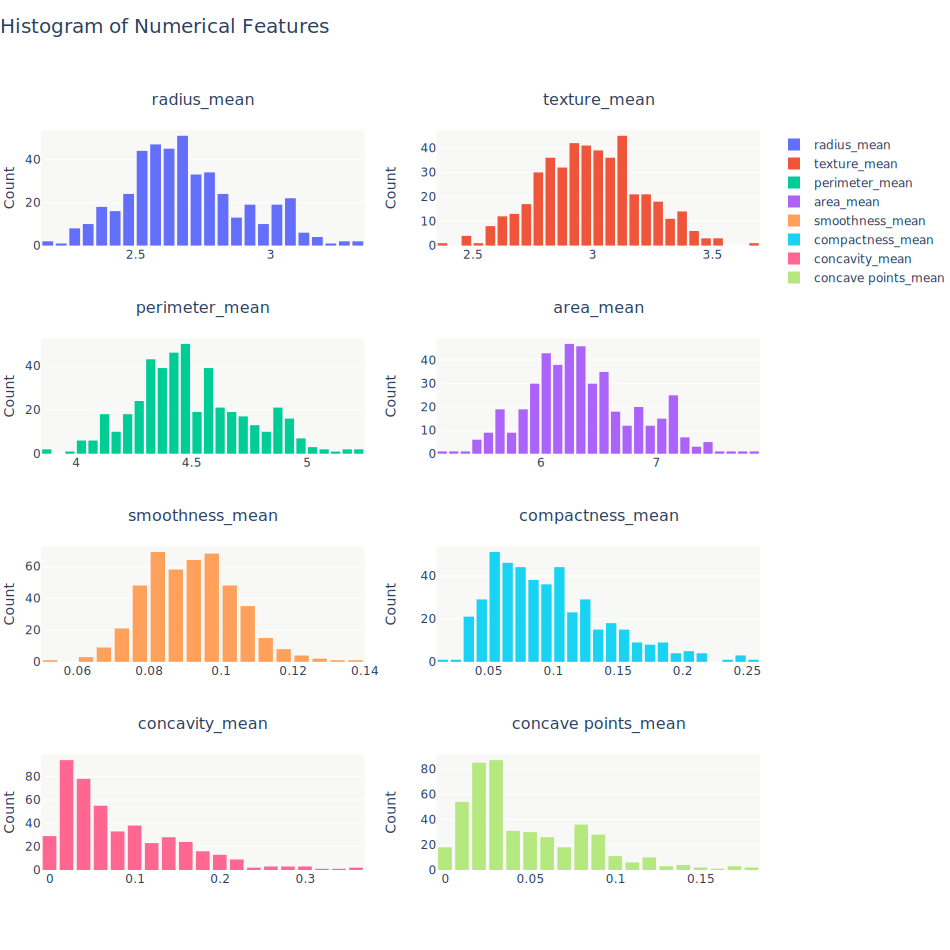

In [8]:
plot_functions.histogram(df=logDf)

* Features Concavity and Concave Points seem to be still skewed, however the rest of the features seem to be more symmetrical thanks to the logarithmic transformation.

**A.3: Testing Hypothesis** <br>
The next step is to test the hypothesis that transforming our data set's scale into log will boost performance of our selected algorithms. Based on the results, we will compare the output against our base benchmarks.

In [9]:
logGBCscore = list()

for i in range(1,6):
    logGBC = functions.model_evaluation()
    logGBC.preprocessing(df)
    logGBC.add_pipe_component("log", FunctionTransformer(np.log1p)) # np.log cannot multiplie 0, so we use np.log1p. 
    logGBC.add_pipe_component("clf", GradientBoostingClassifier())
    logGBC.cross_validation(X, y)
    logGBCscore.append(logGBC.cv_result)

# Our hypothesis is that a standardized dataset will boost model performance.  
functions.hypothesis_testing(np.mean(logGBCscore), benchmarkGBC, "GBC_Log")

We accept the null hypothesis.


In [10]:
logRFCscore = list()

for i in range(1,6):
    logRFC = functions.model_evaluation()
    logRFC.preprocessing(df)
    logRFC.add_pipe_component("log", FunctionTransformer(np.log1p)) # np.log cannot multiplie 0, so we use np.log1p. 
    logRFC.add_pipe_component("clf", RandomForestClassifier())
    logRFC.cross_validation(X, y)
    logRFCscore.append(logRFC.cv_result)

# Our hypothesis is that a standardized dataset will boost model performance.  
functions.hypothesis_testing(np.mean(logRFCscore), benchmarkRFC, "RFC_Log")

We accept the null hypothesis.


In [11]:
logXGBscore = list()

for i in range(1,6):
    logXGB = functions.model_evaluation()
    logXGB.preprocessing(df)
    logXGB.add_pipe_component("log", FunctionTransformer(np.log1p)) # np.log cannot multiplie 0, so we use np.log1p. 
    logXGB.add_pipe_component("clf", XGBClassifier())
    logXGB.cross_validation(X, y)
    logXGBscore.append(logXGB.cv_result)

# Our hypothesis is that a standardized dataset will boost model performance.  
functions.hypothesis_testing(np.mean(logXGBscore), benchmarkXGB, "XGB_Log")

We accept the null hypothesis.


| Model | Model Type | Benchmark |  
|---------|---------|---------|
| **Gradient Boosting Classifier** | Base Model | 95.60% |
| **Random Forest Classifier** | Base Model | 95.38% |
| **XGB Classifier** | Base Model | 95.38% |

**A.4: Standardization** <br>
Now it's time to test out standardizing our dataset. Standardization converts the mean to 0 and a standard deviation of 1. Usually this transform is conducted on Gaussian distributions. Standardizing your dataset can potentially lead you to an uplift in performance. 

In [12]:
sGBCscore = list()

for i in range(1,6):
    sGBC = functions.model_evaluation()
    sGBC.preprocessing(df)
    sGBC.add_pipe_component("s", StandardScaler())  
    sGBC.add_pipe_component("clf", GradientBoostingClassifier())
    sGBC.cross_validation(X, y)
    sGBCscore.append(sGBC.cv_result)

# Our hypothesis is that a standardized dataset will boost model performance.  
functions.hypothesis_testing(np.mean(sGBCscore), benchmarkGBC, "GBC_Standardized")

We accept the null hypothesis.


In [13]:
sRFCscore = list()

for i in range(1,6):
    sRFC = functions.model_evaluation()
    sRFC.preprocessing(df)
    sRFC.add_pipe_component("s", StandardScaler()) 
    sRFC.add_pipe_component("clf", RandomForestClassifier())
    sRFC.cross_validation(X, y)
    sRFCscore.append(sRFC.cv_result)

# Our hypothesis is that a standardized dataset will boost model performance.  
functions.hypothesis_testing(np.mean(sRFCscore), benchmarkRFC, "RFC_Standardized")

We accept the null hypothesis.


In [14]:
sXGBscore = list()

for i in range(1,6):
    sXGB = functions.model_evaluation()
    sXGB.preprocessing(df)
    sXGB.add_pipe_component("s", StandardScaler())
    sXGB.add_pipe_component("clf", XGBClassifier())
    sXGB.cross_validation(X, y)
    sXGBscore.append(sXGB.cv_result)

# Our hypothesis is that a standardized dataset will boost model performance.  
functions.hypothesis_testing(np.mean(sXGBscore), benchmarkXGB, "XGB_Standardized")

We accept the null hypothesis.


| Model | Model Type | Benchmark |  
|---------|---------|---------|
| **Gradient Boosting Classifier** | Base Model | 95.60% |
| **Random Forest Classifier** | Standardized | 95.69% |
| **XGB Classifier** | Base Model | 95.38% |

**A.5: Normalization** <br>
Normalization is the process of rescaling the dataset to the range of 0 to 1.

In [15]:
nGBCscore = list()

for i in range(1,6):
    nGBC = functions.model_evaluation()
    nGBC.preprocessing(df)
    nGBC.add_pipe_component("n", Normalizer())  
    nGBC.add_pipe_component("clf", GradientBoostingClassifier())
    nGBC.cross_validation(X, y)
    nGBCscore.append(nGBC.cv_result)

# Our hypothesis is that a standardized dataset will boost model performance.  
functions.hypothesis_testing(np.mean(nGBCscore), benchmarkGBC, "GBC_Normalized")

We reject the null hypothesis with the new benchmark for GBC_Normalized: 96.4835%


In [16]:
nRFCscore = list()

for i in range(1,6):
    nRFC = functions.model_evaluation()
    nRFC.preprocessing(df)
    nRFC.add_pipe_component("n", Normalizer()) 
    nRFC.add_pipe_component("clf", RandomForestClassifier())
    nRFC.cross_validation(X, y)
    nRFCscore.append(nRFC.cv_result)

# Our hypothesis is that a standardized dataset will boost model performance.  
functions.hypothesis_testing(np.mean(nRFCscore), benchmarkRFC, "RFC_Normalized")

We accept the null hypothesis.


In [17]:
nXGBscore = list()

for i in range(1,6):
    nXGB = functions.model_evaluation()
    nXGB.preprocessing(df)
    nXGB.add_pipe_component("n", Normalizer())
    nXGB.add_pipe_component("clf", XGBClassifier())
    nXGB.cross_validation(X, y)
    nXGBscore.append(nXGB.cv_result)

# Our hypothesis is that a standardized dataset will boost model performance.  
functions.hypothesis_testing(np.mean(nXGBscore), benchmarkXGB, "XGB_Normalized")

We reject the null hypothesis with the new benchmark for XGB_Normalized: 95.8242%


* It looks like our dataset benefited the most from normalization.
* Which makes sense because we have 30+ features at differing scale, so normalization would have a big impact on this particular dataset.

| Model | Model Type | Benchmark |  
|---------|---------|---------|
| **Gradient Boosting Classifier** | Normalized | 96.31% |
| **Random Forest Classifier** | Standardized | 95.69% |
| **XGB Classifier** | Normalized | 95.82% |

&nbsp;

### Section B: Correlation Analysis
Correlation analysis is an important step at understanding the relationships with the underlying data and target variable. It is basically a feature elimination technique used to filter out those features that share a weak correlation (whether its positive or negative), and keep those that share a strong relationship with the labelled data.  

**B.1: Correlation Matrix** <br>
A correlation matrix is a table that displays the correlation between every possible variable. It's a useful visual to measure the correlation of each feature against the target variable.

In [18]:
# As there are too many numerical features we'll visualize the first 7 features + label. 
dfEight = pd.concat([df.iloc[:,:7], df.iloc[:,-1]],axis=1) # Concat the first 7 features and label feature.
dfEight.head(2)

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,diagnosis
id,,,,,,,,
896864,12.98,19.35,84.52,514.0,0.09579,0.11250,0.07107,0
89382601,14.61,15.69,92.68,664.9,0.07618,0.03515,0.01447,0


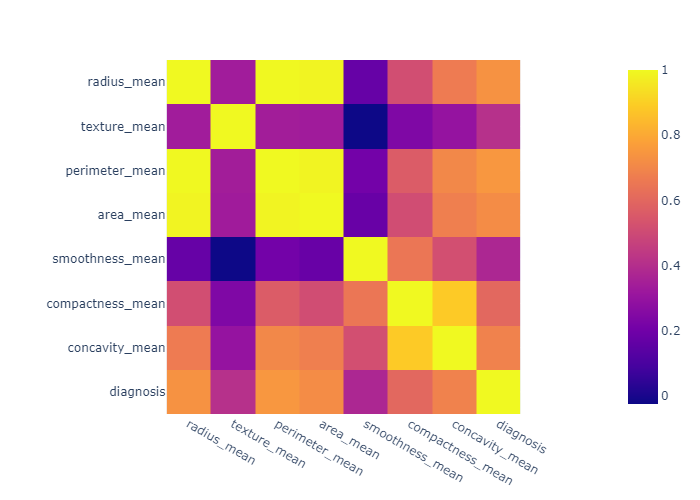

In [19]:
# Transforming our dataframe into pairwise correlation of all columns. 
corr = dfEight.corr()
fig = px.imshow(corr) # Visualizing correlation through heatmap. 
fig.show(renderer="png") # The only way to show this chart inside github is to change render to png. 

* Some of the strongest correlation against our target variable include: radius_mean, periemter_mean, area_mean, concave points_mean, symmetry_se and radius_worst.

**B.2: Scatter Matrix** <br>
A scatter matrix is a matrix of scatterplots with each feature against the target variable. Just like a corrleation matrix, it is a measure of how strong a feature's relationship is with that label.

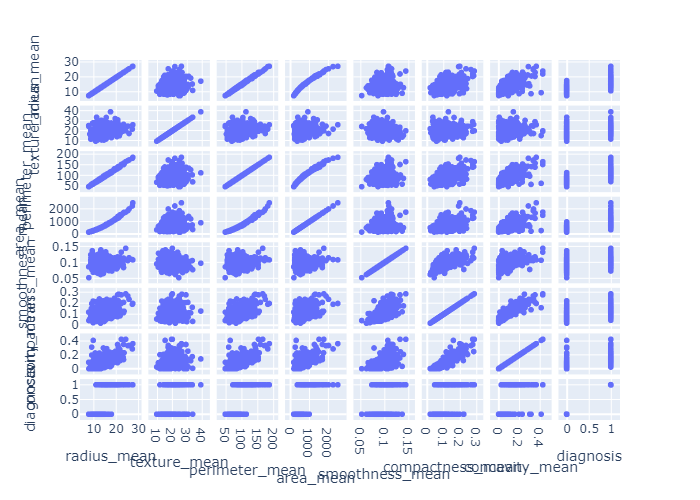

In [20]:
fig = px.scatter_matrix(dfEight) # Plotting scatter matrix. 
fig.show(renderer="png") # Displaying visual.

&nbsp;

### Section C: Recursive Feature Elimination
In this section we'll be focusing on Feature Elimination using scikit-learn's Recrusive Feature Elimination. RFE is a feature elimination technqiue which aims to find the most important features when it comes to predicting our labels. It works through our entire feature space, recursively considering smaller and smaller sets of features. Through each iteration it assigns weights to features (e.g., the feature_importance_ attribute in any classification estimator) and uses this metric to gauge how imporant each feature is at predicting the target variable. At the end of the process, only the most important features are kept.

**C.1: Implementing RFECV with Gradient Boosting Classifier** <br>
Now let's implement RFECV onto our base Gradient Boosting Classifier Model.

In [21]:
rfeGBC = functions.model_evaluation()
# arguments(X, y, model) 
rfeGBC.RFE_cross_validate(X, y, GradientBoostingClassifier())
print("Optimal number of features: %d" % rfeGBC.rfe_result.n_features_)

# Store results into a dictionary. 
dictGBC = rfeGBC.rfe_result.cv_results_

Optimal number of features: 23


**C.2: Implementing RFECV with Random Forest Classifier** <br>
Now let's implement RFECV onto our base Random Forest Classifier Model.

In [22]:
rfeRFC = functions.model_evaluation()
# arguments(X, y, model) 
rfeRFC.RFE_cross_validate(X, y, RandomForestClassifier())
print("Optimal number of features: %d" % rfeRFC.rfe_result.n_features_)

# Store results into a dictionary. 
dictRFC = rfeRFC.rfe_result.cv_results_

Optimal number of features: 17


**C.3: Implementing RFECV with XGB Classifier** <br>
Now let's implement RFECV onto our base XGB Classifier Model.

In [23]:
rfeXGB = functions.model_evaluation()
# arguments(X, y, model) 
rfeXGB.RFE_cross_validate(X, y, XGBClassifier())
print("Optimal number of features: %d" % rfeXGB.rfe_result.n_features_)

# Store results into a dictionary. 
dictXGB = rfeXGB.rfe_result.cv_results_

Optimal number of features: 15


**C.4: Plotting the RFECV Output** <br>
Now let's plot the weighted recall against the number of features for each algorithm to see at which point the optimal number of features were selected.

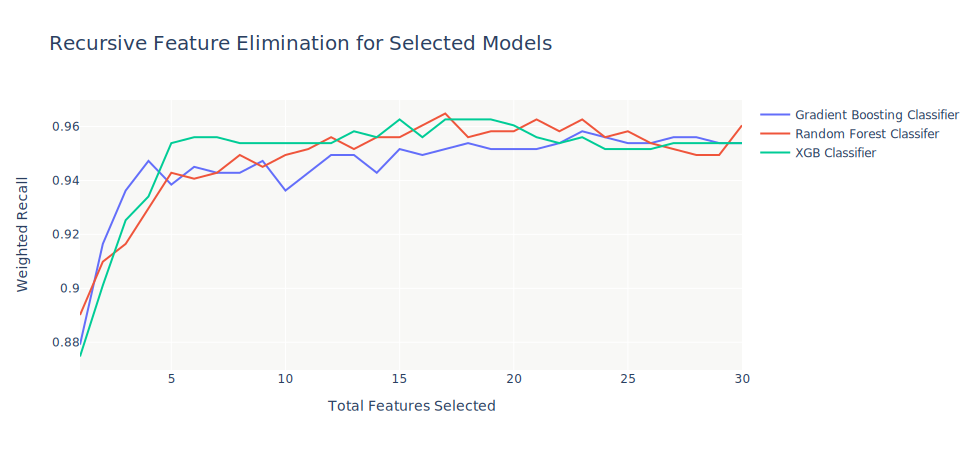

In [24]:
# Setting up axes values. 
x_axis = list(range(1, len(dictGBC['mean_test_score']) + 1)) # Maximum no. of features. 
y_GBC = dictGBC['mean_test_score']
y_RFC = dictRFC['mean_test_score']
y_XGB = dictXGB['mean_test_score']

plot_functions.plot_rfe(xaxis=x_axis, yGBC=y_GBC, yRFC=y_RFC, yXGB=y_XGB)

&nbsp;

&nbsp;
**Author:** Aaron Chew&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **|** &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Date Published:** 11/08/2022 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**|** &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Email:** aaronsamuelchew@gmail.com &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**|**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **GitHub:** https://github.com/aaron-chew  